# Handwritten optical character recognition 

--- 

Optical Character recognition (OCR) with RNN Encoder-Decoder model. <br>
The character recognition model will be trained in the notebook and the model will be used in several apps (iOS/Android) <br>
<br>
**Steps:**
 * Imports and setups
 * Data loading and preprocessing
 * CTC setup
 * Model setup and training
 * Evaluation and analysis

# Importing and setup 
This step contains importing all needed libraries and defining hyperparameters and variables. 

In [1]:
# import all tensorflow related libraries
import tensorflow as tf
import tensorflow.data as tfd
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, load_model 
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# import other libraries
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
from glob import glob
import matplotlib.pyplot as plt
import matplotlib.image as implt
from IPython.display import clear_output as cls

2024-05-17 11:44:11.861763: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-17 11:44:11.895382: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-17 11:44:11.895415: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-17 11:44:11.895442: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-17 11:44:11.902848: I tensorflow/core/platform/cpu_feature_g

## Defining the necessary variables 

In [2]:
IMG_WIDTH = 200
IMG_HEIGHT = 50
IMG_SIZE = (IMG_WIDTH, IMG_HEIGHT)
BATCH_SIZE = 8
EPOCHS = 75
LEARNING_RATE = 1e-3
MODEL_NAME = "CharacterRecognition-Model"
TRAIN_SIZE = BATCH_SIZE * 3000
VALID_SIZE = BATCH_SIZE * 1500
TEST_SIZE  = BATCH_SIZE * 300
AUTOTUNE = tfd.AUTOTUNE

# Training callbacks 
CALLBACKS = [
    EarlyStopping(patience=10, restore_best_weights=True),
    ModelCheckpoint(filepath=MODEL_NAME + ".h5", save_best_only=True)
]

# Paths 
train_csv_path = 'Dataset/IAM/train.csv'
valid_csv_path = 'Dataset/IAM/val.csv'
# test_csv_path = 'data/CSV/written_name_test.csv'
train_image_dir = 'Dataset/IAM/words'
valid_image_dir = 'Dataset/IAM/words'
# test_image_dir = 'data/test_v2/test'

# SetUp random seeds for numpy and TensorFlow
np.random.seed(2569)
tf.random.set_seed(2569)

In [33]:
test_csv_path = 'Dataset/IAM/test.csv'
test_image_dir = 'Dataset/IAM/Imgs'

# Data loading and Preprocessing 
The datas are divided into 2 parts:
* Labels and File paths
* Images
<br>
There are some variables defined with `csv_path` at the end of their names. Those are the files that contain the **labels** and **file paths** for them. <br>
The images are stored in the paths where their variables are defined with the ending of `image_dir`.

---

First the `.csv` files are loaded. After that the labels and their file paths get extracted. After that, the labels are processed and the images are loaded based on the file names of the labels. At the end the images also get preprocessed to be ready for getting feeded to the model. 

In [3]:
# load the csv files 
train_csv = pd.read_csv(train_csv_path, names=['path','text'])[:TRAIN_SIZE]
# test_csv = pd.read_csv(test_csv_path)[:TEST_SIZE]
valid_csv = pd.read_csv(valid_csv_path,  names=['path','text'])[:VALID_SIZE]

In [39]:
test_csv = pd.read_csv(test_csv_path, names=['path'])[:TEST_SIZE]

In [40]:
test_csv.head()

,path
0,Imgs/croped7.png
1,Imgs/samlpe_7_cp.jpg
2,Imgs/samlpe_7.jpg
3,Imgs/samlpe_1.jpg
4,Imgs/samlpe_2.jpg


### Load the train labels 
The labels will target the images. They basically attach a class to each image. <br>
As mentioned before, the labels are in the `.csv` files in the column named `IDENTITY`. <br> 

In [5]:
# get the train labels 
train_labels = [str(word) for word in train_csv['text'].to_numpy()]

In [6]:
# extract all the unique characters
unique_characters = set(char for word in train_labels for char in word)
# define the number of classes (for labels) based on the number of unique characters
n_classes = len(unique_characters)

In [7]:
print(f"Number of unique classes(unique characters): {n_classes}")

Number of unique classes(unique characters): 75


In [8]:
# get the maximum length that a label can have 
MAX_LABEL_LENGTH = max(map(len, train_labels))

In [9]:
print(f"The length of the longest label in the datase: {MAX_LABEL_LENGTH}")

The length of the longest label in the datase: 18


### Load the images paths
In the `.csv` files, there paths for the images related to each label. However, there are only the names of the images. So, they have to preprocessed and the path of them must also be added to them. This step is crucial for loading images.

In [10]:
train_csv['path'] = [train_image_dir + f"/{filename}" for filename in train_csv['path']]
valid_csv['path'] = [valid_image_dir + f"/{filename}" for filename in valid_csv['path']]


In [41]:
test_csv['path']  = [test_image_dir + f"/{filename}" for filename in test_csv['path']]

## Label preprocessing
2 Dictionaries must be created. One for mapping characters to numerical values and one for mapping numerical values to characters

In [12]:
# Char to Num
char_to_num = StringLookup(vocabulary=list(unique_characters), mask_token=None)
num_to_char = StringLookup(vocabulary = char_to_num.get_vocabulary(), mask_token = None, invert = True)

2024-05-17 11:44:14.046497: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 17566 MB memory:  -> device: 0, name: NVIDIA RTX A4500, pci bus id: 0000:47:00.0, compute capability: 8.6


In [13]:
len(char_to_num.get_vocabulary())+1

77

## Image preprocessing 
**To Function must be used for image preprocessing part:** <br>
The first function is `load_image`. This function loads the images and returns the image as an `numpy` array. <br>
The second function is used for both images and labels. It gets the data and returns the encoded versions of them. 

In [14]:
def load_image(image_path):
    """
    This function gets the image path and 
    reads the image using TensorFlow, Then the image will be decoded and 
    will be converted to float data type. next resize and transpose will be applied to it.
    In the final step the image will be converted to a Numpy Array using tf.cast
    """
    # read the image
    image = tf.io.read_file(image_path)
    # decode the image
    decoded_image = tf.image.decode_jpeg(contents=image, channels=1)
    # convert image data type to float32
    convert_imgs = tf.image.convert_image_dtype(image=decoded_image, dtype=tf.float32)
    # resize and transpose 
    resized_image = tf.image.resize(images=convert_imgs, size=(IMG_HEIGHT, IMG_WIDTH))
    image = tf.transpose(resized_image, perm = [1, 0, 2])

    # to numpy array (Tensor)
    image_array = tf.cast(image, dtype=tf.float32)

    return image_array

In [43]:
def encode_single_sample(image_path, label:str):
    
    '''
    The function takes an image path and label as input and returns a dictionary containing the processed image tensor and the label tensor. 
    First, it loads the image using the load_image function, which decodes and resizes the image to a specific size. Then it converts the given
    label string into a sequence of Unicode characters using the unicode_split function. Next, it uses the char_to_num layer to convert each
    character in the label to a numerical representation. It pads the numerical representation with a special class (n_classes)
    to ensure that all labels have the same length (MAX_LABEL_LENGTH). Finally, it returns a dictionary containing the processed image tensor
    and the label tensor.
    
    '''
    
    # Get the image
    image = load_image(image_path)
    # Convert the label into characters
    chars = tf.strings.unicode_split(label, input_encoding='UTF-8')
    # Convert the characters into vectors
    vecs = char_to_num(chars)

    vecs = vecs[:MAX_LABEL_LENGTH]
    
    # Pad label
    pad_size = MAX_LABEL_LENGTH - tf.shape(vecs)[0]
    pad_size = tf.maximum(pad_size, 0)
    vecs = tf.pad(vecs, paddings = [[0, pad_size]], constant_values=n_classes+1)
    
    return {'image':image, 'label':vecs}

In [16]:
# Training Data
train_ds = tf.data.Dataset.from_tensor_slices(
    (np.array(train_csv['path'].to_list()), np.array(train_csv['text'].to_list()))
).shuffle(1000).map(encode_single_sample, num_parallel_calls=AUTOTUNE).batch(BATCH_SIZE).prefetch(AUTOTUNE)

# Validation data
valid_ds = tf.data.Dataset.from_tensor_slices(
    (np.array(valid_csv['path'].to_list()), np.array(valid_csv['text'].to_list()))
).map(encode_single_sample, num_parallel_calls=AUTOTUNE).batch(BATCH_SIZE).prefetch(AUTOTUNE)



In [47]:
def encode_single_test_sample(image_path):
    image = load_image(image_path)
    return {'image':image}

In [48]:
# # Testing data.
test_ds = tf.data.Dataset.from_tensor_slices(
    (np.array(test_csv['path'].to_list()))
).map(encode_single_test_sample, num_parallel_calls=AUTOTUNE).batch(BATCH_SIZE).prefetch(AUTOTUNE)

In [17]:
# import os
# import numpy as np
# import pandas as pd
# from PIL import Image
# import tensorflow as tf

# # AUTOTUNE = tf.data.AUTOTUNE
# # BATCH_SIZE = 32
# # MAX_LABEL_LENGTH = 100  # Example value, set according to your needs
# # n_classes = 26  # Example value, set according to your needs

# # Mock char_to_num and load_image functions
# # Replace these with your actual implementations
# char_to_num = tf.keras.layers.StringLookup(vocabulary=list('abcdefghijklmnopqrstuvwxyz'), mask_token=None)
# # def load_image(image_path):
# #     image = tf.io.read_file(image_path)
# #     image = tf.image.decode_jpeg(image, channels=3)
# #     image = tf.image.resize(image, [128, 128])  # Resize to the desired size
# #     return image


# def load_image(image_path):
#     """MAX_LABEL_LENGTH
#     This function gets the image path and 
#     reads the image using TensorFlow, Then the image will be decoded and 
#     will be converted to float data type. next resize and transpose will be applied to it.
#     In the final step the image will be converted to a Numpy Array using tf.cast
#     """
#     # read the image
#     image = tf.io.read_file(image_path)
#     # decode the image
#     decoded_image = tf.image.decode_jpeg(contents=image, channels=1)
#     # convert image data type to float32
#     convert_imgs = tf.image.convert_image_dtype(image=decoded_image, dtype=tf.float32)
#     # resize and transpose 
#     resized_image = tf.image.resize(images=convert_imgs, size=(IMG_HEIGHT, IMG_WIDTH))
#     image = tf.transpose(resized_image, perm = [1, 0, 2])

#     # to numpy array (Tensor)
#     image_array = tf.cast(image, dtype=tf.float32)

#     return image_array

# def check_images(paths):
#     valid_files = []
#     for file_path in paths:
#         # print(file_path)
#         try:
#             img = Image.open('Dataset/IAM/words/' + file_path)
#             # print(img)
#             img.verify()  # Verify that it is an image
#             valid_files.append(file_path)
#         except (IOError, SyntaxError) as e:
#             print(f"Corrupt file: {file_path}")
#     return valid_files

# def encode_single_sample(image_path, label):
#     image = load_image(image_path)
#     chars = tf.strings.unicode_split(label, input_encoding='UTF-8')
#     vecs = char_to_num(chars)
    
#     # Pad label
#     pad_size = MAX_LABEL_LENGTH - tf.shape(vecs)[0]
#     vecs = tf.pad(vecs, paddings=[[0, pad_size]], constant_values=n_classes + 1)
    
#     return {'image': image, 'label': vecs}

# def load_dataset(file_paths, labels):
#     dataset = tf.data.Dataset.from_tensor_slices((file_paths, labels))
#     dataset = dataset.map(lambda x, y: encode_single_sample(x, y), num_parallel_calls=AUTOTUNE)
#     dataset = dataset.filter(lambda x: x['image'] is not None)  # Filter out None values
#     dataset = dataset.shuffle(buffer_size=1000)
#     dataset = dataset.batch(BATCH_SIZE)
#     dataset = dataset.prefetch(buffer_size=AUTOTUNE)
#     return dataset

# def clean():
#     # Assuming train_csv and valid_csv are already loaded DataFrames
#     train_csv = pd.read_csv('Dataset/IAM/train.csv')
#     valid_csv = pd.read_csv('Dataset/IAM/val.csv')

#     train_paths = np.array(train_csv['path'].to_list())
#     train_texts = np.array(train_csv['text'].to_list())

#     valid_paths = np.array(valid_csv['path'].to_list())
#     valid_texts = np.array(valid_csv['text'].to_list())

#     valid_train_paths = check_images(train_paths)
#     valid_valid_paths = check_images(valid_paths)

#     valid_train_texts = [train_texts[i] for i, path in enumerate(train_paths) if path in valid_train_paths]
#     valid_valid_texts = [valid_texts[i] for i, path in enumerate(valid_paths) if path in valid_valid_paths]

#     train_ds = load_dataset(np.array(valid_train_paths), np.array(valid_train_texts))
#     valid_ds = load_dataset(np.array(valid_valid_paths), np.array(valid_valid_texts))

#     return train_ds, valid_ds
#     # Example model definition and compilation
# #     model = tf.keras.Sequential([
# #         tf.keras.layers.InputLayer(input_shape=(128, 128, 3)),  # Adjust input shape as needed
# #         tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
# #         tf.keras.layers.MaxPooling2D((2, 2)),
# #         tf.keras.layers.Flatten(),
# #         tf.keras.layers.Dense(64, activation='relu'),
# #         tf.keras.layers.Dense(n_classes + 1, activation='softmax')  # Adjust output layer for your use case
# #     ])
# #     model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# #     # Train the model
# #     model.fit(train_ds, validation_data=valid_ds, epochs=10)  # Adjust epochs as needed

# # if __name__ == "__main__":
# #     main()


In [18]:
# train_ds, val_ds = clean()

In [19]:
train_ds

<_PrefetchDataset element_spec={'image': TensorSpec(shape=(None, 200, 50, 1), dtype=tf.float32, name=None), 'label': TensorSpec(shape=(None, None), dtype=tf.int64, name=None)}>

In [20]:
train_ds

<_PrefetchDataset element_spec={'image': TensorSpec(shape=(None, 200, 50, 1), dtype=tf.float32, name=None), 'label': TensorSpec(shape=(None, None), dtype=tf.int64, name=None)}>

In [49]:
# check the data distribution 
print(f"Training Data Size   : {tf.data.Dataset.cardinality(train_ds).numpy() * BATCH_SIZE}")
print(f"Validation Data Size : {tf.data.Dataset.cardinality(valid_ds).numpy() * BATCH_SIZE}")
print(f"Testing Data Size    : {tf.data.Dataset.cardinality(test_ds).numpy() * BATCH_SIZE}")

Training Data Size   : 24000
Validation Data Size : 12000
Testing Data Size    : 16


### Explore the dataset 
See some images 

In [22]:
def show_images(data, GRID=[4,4], FIGSIZE=(25, 8), cmap='binary_r', model=None, decode_pred=None):
    
    # Plotting configurations
    plt.figure(figsize=FIGSIZE)
    n_rows, n_cols = GRID
    
    # Loading Data 
    data = next(iter(data))
    images, labels = data['image'], data['label']
    
    # Iterate over the data 
    for index, (image, label) in enumerate(zip(images, labels)):
        
        # Label processing
        text_label = num_to_char(label)
        text_label = tf.strings.reduce_join(text_label).numpy().decode('UTF-8')
        text_label = text_label.replace("[UNK]", " ").strip()
        
        # Create a sub plot
        plt.subplot(n_rows, n_cols, index+1)
        plt.imshow(tf.transpose(image, perm=[1,0,2]), cmap=cmap)
        plt.axis('off')
        
        if model is not None and decode_pred is not None:
            # Make prediction
            pred = model.predict(tf.expand_dims(image, axis=0))
            pred = decode_pred(pred)[0]
            title = f"True : {text_label}\nPred : {pred}"
            plt.title(title)
        else:
            # add title
            plt.title(text_label)

    # Show the final plot
    cls()
    plt.show()

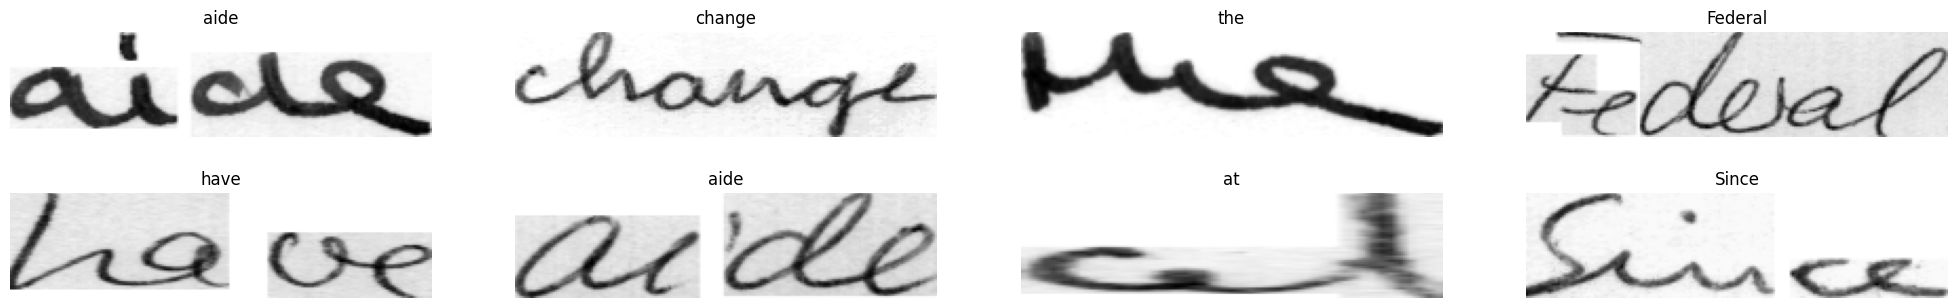

In [23]:
show_images(data=train_ds, cmap='gray')

# Neural Net Model and Training
The data has been readeed and preprocessed and everything is *go* for model training. <br>

---

**There are 4 main sections in the model training part:**
* CTC Loss (more explaination in its dedicated section)
* Model Creation
* Training
* Testing and evaluation 

## CTC Loss
---
### Short Explaination:
**The *Connectionist Temporal Classification*(CTC) loss is used for seq2seq tasks.** <br>
In this case, the **CTC Loss** will take the ***Predicted Sequence of Characters*** and the ***label*** and calculates how far are they from each other. <br>
The **other task** of CTC is to align the the length of predicted sequence and the label by addin blank spaces. 

---
### Implementation:
A class named `CTCLayer` is going to be defined. The input length and the predicted length are going to be taken. Then the loss

In [24]:
class CTCLayer(Layer):
    def __init__(self, **kwargs) -> None:
        super().__init__(**kwargs)

        # define the loss function 
        self.loss_function = tf.keras.backend.ctc_batch_cost

    def call(self, y_true, y_hat):
        # Get the batch length 
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")

        # get the input and label lengths
        input_len = tf.cast(tf.shape(y_hat)[1], dtype='int64') * tf.ones(shape=(batch_len, 1), dtype='int64')
        label_len = tf.cast(tf.shape(y_true)[1], dtype='int64') * tf.ones(shape=(batch_len, 1), dtype='int64')

        # calculate the loss
        loss = self.loss_function(y_true, y_hat, input_len, label_len) 

        self.add_loss(loss)

        return y_hat

## Model Creation
The model used is a Encoder-Decoder Model which means it is a combinatio of CNN and RNN. <br>

--- 

#### Model Architecture:
The model has 2 Convolutional layers followed by MaxPools. <br>
The encoding space has one Dense layer. The Decoder network is consist of 2 Bidirectional LSTM layers. 

In [25]:
# Input Layer
input_images = Input(shape=(IMG_WIDTH, IMG_HEIGHT, 1), name="image")

# Labels : These are added for the training purpose.
input_labels = Input(shape=(None, ), name="label")

### Convolutional layers
# layer 1 
conv_1 = Conv2D(64, 3, strides=1, padding="same", kernel_initializer="he_normal", activation="relu", name="conv_1")(input_images)
# layer 2
conv_2 = Conv2D(32, 3, strides=1, padding="same", kernel_initializer="he_normal", activation="relu", name="conv_2")(conv_1)
max_pool_1 = MaxPool2D(pool_size=(2, 2), strides=(2, 2))(conv_2)
# layer 3
conv_3 = Conv2D(64, 3, strides=1, padding='same', activation='relu', kernel_initializer='he_normal', name="conv_3")(max_pool_1)
conv_4 = Conv2D(32, 3, strides=1, padding='same', activation='relu', kernel_initializer='he_normal', name="conv_4")(conv_3)
max_pool_2 = MaxPool2D(pool_size=(2, 2), strides=(2, 2))(conv_4)



### Encoding 
reshape = Reshape(target_shape=((IMG_WIDTH//4), (IMG_HEIGHT//4)*32), name="reshape_layer")(max_pool_2)
dense_encoding = Dense(64, kernel_initializer="he_normal", activation="relu", name="enconding_dense")(reshape)
dense_encoding_2 = Dense(64, kernel_initializer="he_normal", activation="relu", name="enconding_dense_2")(dense_encoding)
dropout = Dropout(0.4)(dense_encoding_2)

# Decoder
lstm_1 = Bidirectional(LSTM(128, return_sequences=True, dropout=0.25), name="bidirectional_lstm_1")(dropout)
lstm_2 = Bidirectional(LSTM(64, return_sequences=True, dropout=0.25), name="bidirectional_lstm_2")(lstm_1)

# Final Output layer
output = Dense(len(char_to_num.get_vocabulary())+1, activation="softmax", name="output_dense")(lstm_2)

# Add the CTC loss 
ctc_loss_layer = CTCLayer()(input_labels, output) 

# Define the final model
model = Model(inputs=[input_images, input_labels], outputs=[ctc_loss_layer])

In [26]:
# draw the model plot
tf.keras.utils.plot_model(
    model,
    to_file='model-graph.png'
)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [27]:
# see the model summary 
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image (InputLayer)          [(None, 200, 50, 1)]         0         []                            
                                                                                                  
 conv_1 (Conv2D)             (None, 200, 50, 64)          640       ['image[0][0]']               
                                                                                                  
 conv_2 (Conv2D)             (None, 200, 50, 32)          18464     ['conv_1[0][0]']              
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 100, 25, 32)          0         ['conv_2[0][0]']              
 D)                                                                                           

### Model Training 

In [28]:
# compile the model
model.compile(optimizer="adam")

In [29]:
# train the model
history = model.fit(train_ds, validation_data=valid_ds, epochs=EPOCHS, callbacks=CALLBACKS)

Epoch 1/75


2024-05-17 11:44:20.076645: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2024-05-17 11:44:21.257788: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7c1a4c0a9700 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-05-17 11:44:21.257807: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA RTX A4500, Compute Capability 8.6
2024-05-17 11:44:21.261436: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-05-17 11:44:21.348360: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


3000/3000 [==============================] - 52s 15ms/step - loss: 13.9406 - val_loss: 10.5033
Epoch 2/75
  11/3000 [..............................] - ETA: 35s - loss: 12.8087

/home/wesee/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3000/3000 [==============================] - 45s 15ms/step - loss: 10.7051 - val_loss: 8.5254
Epoch 3/75
3000/3000 [==============================] - 45s 15ms/step - loss: 8.8964 - val_loss: 7.1984
Epoch 4/75
3000/3000 [==============================] - 45s 15ms/step - loss: 7.1002 - val_loss: 5.9672
Epoch 5/75
3000/3000 [==============================] - 45s 15ms/step - loss: 5.8957 - val_loss: 5.2521
Epoch 6/75
3000/3000 [==============================] - 46s 15ms/step - loss: 5.1339 - val_loss: 4.9603
Epoch 7/75
3000/3000 [==============================] - 46s 15ms/step - loss: 4.5997 - val_loss: 4.5408
Epoch 8/75
3000/3000 [==============================] - 46s 15ms/step - loss: 4.2271 - val_loss: 4.3745
Epoch 9/75
3000/3000 [==============================] - 46s 15ms/step - loss: 3.9202 - val_loss: 4.2638
Epoch 10/75
3000/3000 [==============================] - 46s 15ms/step - loss: 3.6968 - val_loss: 4.1910
Epoch 11/75
3000/3000 [==============================] - 46s 15ms/step - 

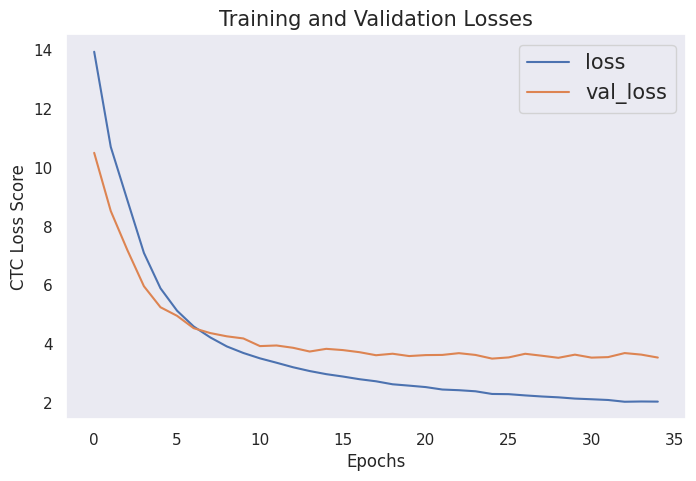

In [32]:
import seaborn as sb
# draw plot for results 
sb.set()
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.legend(fontsize=15)
plt.xlabel("Epochs")
plt.ylabel("CTC Loss Score")
plt.title("Training and Validation Losses", fontsize=15)
plt.grid()
plt.savefig("model_result.png")
plt.show()



## Testing and Evaluation

In [50]:
# evaluate the model on the test dataset 
evaluation = model.evaluate(test_ds)
print(f"evaluation loss: {evaluation}")

ValueError: in user code:

    File "/home/wesee/.local/lib/python3.10/site-packages/keras/src/engine/training.py", line 2042, in test_function  *
        return step_function(self, iterator)
    File "/home/wesee/.local/lib/python3.10/site-packages/keras/src/engine/training.py", line 2025, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/wesee/.local/lib/python3.10/site-packages/keras/src/engine/training.py", line 2013, in run_step  **
        outputs = model.test_step(data)
    File "/home/wesee/.local/lib/python3.10/site-packages/keras/src/engine/training.py", line 1893, in test_step
        y_pred = self(x, training=False)
    File "/home/wesee/.local/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/home/wesee/.local/lib/python3.10/site-packages/keras/src/engine/input_spec.py", line 197, in assert_input_compatibility
        raise ValueError(

    ValueError: Missing data for input "label". You passed a data dictionary with keys ['image']. Expected the following keys: ['image', 'label']


In [53]:
def decoder_prediction(pred_label):
    """
    This function has the job to decode the prediction that the model had.
    The model predicts each character and then this function makes it readable. 
    """
    # Input length
    input_len = np.ones(shape=pred_label.shape[0]) * pred_label.shape[1]
    
    # CTC decode
    decode = tf.keras.backend.ctc_decode(pred_label, input_length=input_len, greedy=True)[0][0][:,:MAX_LABEL_LENGTH]
    
    # Converting numerics back to their character values
    chars = num_to_char(decode)
    
    # Join all the characters
    texts = [tf.strings.reduce_join(inputs=char).numpy().decode('UTF-8') for char in chars]
    
    # Remove the unknown token
    filtered_texts = [text.replace('[UNK]', " ").strip() for text in texts]
    
    return filtered_texts

In [54]:
# define a model for testing and evaluation 
pred_model = Model(inputs=model.get_layer(name="image").input, outputs=model.get_layer(name='output_dense').output)

In [55]:
show_images(data=test_ds, model=pred_model, decode_pred=decoder_prediction, cmap='binary')

2024-05-17 12:35:03.352575: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at whole_file_read_ops.cc:116 : NOT_FOUND: Dataset/IAM/Imgs/Imgs/samlpe_7_cp.jpg; No such file or directory
2024-05-17 12:35:03.352692: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at whole_file_read_ops.cc:116 : NOT_FOUND: Dataset/IAM/Imgs/Imgs/samlpe_2.jpg; No such file or directory
2024-05-17 12:35:03.352761: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at whole_file_read_ops.cc:116 : NOT_FOUND: Dataset/IAM/Imgs/Imgs/samlpe_9.jpg; No such file or directory
2024-05-17 12:35:03.352809: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at whole_file_read_ops.cc:116 : NOT_FOUND: Dataset/IAM/Imgs/Imgs/samlpe_1.jpg; No such file or directory
2024-05-17 12:35:03.352962: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at whole_file_read_ops.cc:116 : NOT_FOUND: Dataset/IAM/Imgs/Imgs/samlpe_3.jpg; No such file or directory
20

NotFoundError: {{function_node __wrapped__IteratorGetNext_output_types_1_device_/job:localhost/replica:0/task:0/device:CPU:0}} Dataset/IAM/Imgs/Imgs/croped7.png; No such file or directory
	 [[{{node ReadFile}}]] [Op:IteratorGetNext] name: 

<Figure size 2500x800 with 0 Axes>

### Single Sample prediction

In [56]:
def single_sample_prediction(model, path):
    """
    This function gets an image path and the model,
    Loads and preprocesses the image and make predictions on it. 
    """
    # load image 
    image_loading = tf.io.read_file(path)
    # decode image 
    decoded_image = tf.image.decode_jpeg(contents=image_loading, channels=1)
    # convert the image data type to float 
    convert_image = tf.image.convert_image_dtype(image=decoded_image, dtype=tf.float32)
    # resize the image 
    resized_image = tf.image.resize(images=convert_image, size=(IMG_HEIGHT, IMG_WIDTH))
    resized_image = tf.transpose(resized_image, perm = [1, 0, 2])
    # convert image to array
    image_array = tf.cast(resized_image, dtype=tf.float32)
    # reshape image 
    single_image_data_with_batch = np.expand_dims(image_array, axis=0)

    # make prediction 
    prediction = decoder_prediction(model.predict(single_image_data_with_batch))

    return prediction 

1/1 [==============================] - 0s 34ms/step


['noNE']


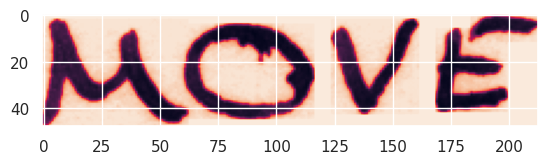

In [68]:
# prediction 1:
img_1_path = "Dataset/IAM/words/a01/a01-000u/a01-000u-00-01.png"
img_1 = implt.imread(img_1_path)
plt.imshow(img_1)
print(single_sample_prediction(pred_model, img_1_path))

1/1 [==============================] - 0s 37ms/step


['srsesesur']


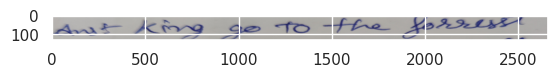

In [65]:
# prediction 2:
img_2_path = "Dataset/IAM/Imgs/croped7.png"
img_2 = implt.imread(img_2_path)
plt.imshow(img_2)
print(single_sample_prediction(pred_model, img_2_path))

In [66]:
# prediction 3:
img_3_path = "data\\test_v2\\test\\TEST_0684.jpg"
img_3 = implt.imread(img_3_path)
plt.imshow(img_3)
print(single_sample_prediction(pred_model, img_3_path))

FileNotFoundError: [Errno 2] No such file or directory: 'data\\test_v2\\test\\TEST_0684.jpg'

### Saving the model

In [67]:
# save the model
model.save("model.hd5")
# save weights
model.save_weights("model_weights.hd5")

INFO:tensorflow:Assets written to: model.hd5/assets


INFO:tensorflow:Assets written to: model.hd5/assets
